In [7]:
import numpy as np
import scanpy as sc
import pandas as pd
import evaluate
import pickle
import torch
import random
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from torch_optimizer import Lamb
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_scheduler
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from Bio import SeqIO
import tqdm as tq
import time
import os
from datetime import timedelta

os.environ["TOKENIZERS_PARALLELISM"] = "false"
np.set_printoptions(threshold=2200)
torch.set_printoptions(threshold=2200)
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [8]:
MODEL_NAME, MODEL_PRINT_NAME = "hunarbatra/CoVBERT", "CoVBERT"
VOC_NAMES = ["Alpha", "Beta", "Delta", "Gamma", "Omicron"]

In [9]:
print(torch.cuda.is_available())

True


In [10]:
tok = AutoTokenizer.from_pretrained(MODEL_NAME, do_lower_case=False)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(VOC_NAMES))

num_params = sum(p.numel() for p in model.parameters())
print("Number of parameters in model: ", num_params)

Some weights of the model checkpoint at hunarbatra/CoVBERT were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at hunarbatra/CoVBERT and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
Y

Number of parameters in model:  44897285


In [11]:
df = pd.DataFrame()

for i, voc_name in enumerate(VOC_NAMES):
    voc_df = pd.read_csv(f"data/unique_{voc_name}_2k.csv")
    voc_df['label'] = i
    df = pd.concat([df, voc_df])

df = df.drop(['accession_id', 'date'], axis=1)
df = df.reset_index(drop=True)

In [12]:
df

,sequence,label
0,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0
1,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0
2,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0
3,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0
4,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0
...,...,...
9995,MFVFLVLLPLVSSQCVNLITRTQSYTNSFTRGVYYPDKVFRSSVXX...,4
9996,TQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHA...,4
9997,TQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHA...,4
9998,MFVFLVLLPLVSSQCVNLITRTQSYTNSFTRGVYYPDKVFRSSVLH...,4


In [13]:
X_train, X_test, y_train, y_test = train_test_split(df['sequence'],
                                                    df['label'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['label'])

In [14]:
df_train = pd.DataFrame({'sequence': X_train, 'label': y_train}).reset_index(drop=True)
df_test = pd.DataFrame({'sequence': X_test, 'label': y_test}).reset_index(drop=True)

In [15]:
ds_train = Dataset.from_pandas(df_train)
ds_test = Dataset.from_pandas(df_test)

# TOKENIZE

In [16]:
# Funtion to tokenize data
def tokenize_dataset(dataset, tok, embedding_size):
    return tok(
        dataset['sequence'],
        max_length=embedding_size,
        truncation=True,
        padding="max_length")
    

# Tokenize the dataset
dataset_train = ds_train.map(tokenize_dataset, fn_kwargs={'tok': tok, 'embedding_size': EMBED_SIZE})
dataset_test = ds_test.map(tokenize_dataset, fn_kwargs={'tok': tok, 'embedding_size': EMBED_SIZE})

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [17]:
print(dataset_train)
print(dataset_test)

Dataset({
    features: ['sequence', 'label', 'input_ids', 'attention_mask'],
    num_rows: 8000
})
Dataset({
    features: ['sequence', 'label', 'input_ids', 'attention_mask'],
    num_rows: 2000
})


In [18]:
# Remove the sequence column because it will not be used in the model
dataset_train = dataset_train.remove_columns(['sequence'])
dataset_test = dataset_test.remove_columns(['sequence'])

# Rename label to labels because the model expects the name labels
dataset_train = dataset_train.rename_column("label", "labels")
dataset_test = dataset_test.rename_column("label", "labels")

# Change the format to PyTorch tensors
dataset_train.set_format("torch")
dataset_test.set_format("torch")

# Take a look at the data
print(dataset_train)
print(dataset_test)

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 8000
})
Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 2000
})


In [19]:
# Empty cache
torch.cuda.empty_cache()

# DataLoader
train_dataloader = DataLoader(dataset=dataset_train, shuffle=True, batch_size=16)
eval_dataloader = DataLoader(dataset=dataset_test, batch_size=16)

In [20]:
for batch in eval_dataloader:
    item = batch["input_ids"][0]
    print(len(item))
    print(item)
    break

2048
tensor([ 0, 49, 42, 58, 42, 48, 58, 48, 48, 52, 48, 58, 55, 55, 53, 39, 58, 50,
        48, 56, 56, 54, 56, 53, 48, 52, 52, 37, 61, 56, 50, 55, 42, 56, 54, 43,
        58, 61, 61, 60, 40, 47, 58, 42, 54, 55, 55, 58, 48, 44, 55, 56, 53, 40,
        48, 42, 48, 52, 42, 42, 55, 50, 58, 56, 59, 42, 44, 37, 45, 55, 43, 56,
        50, 43, 56, 47, 54, 42, 40, 50, 52, 58, 48, 52, 42, 50, 40, 43, 58, 61,
        42, 37, 55, 56, 41, 47, 55, 50, 45, 45, 54, 43, 59, 45, 42, 43, 56, 56,
        48, 40, 55, 47, 56, 53, 55, 48, 48, 45, 58, 50, 50, 37, 56, 50, 58, 58,
        45, 47, 58, 39, 41, 42, 53, 42, 39, 50, 40, 52, 42, 48, 43, 58, 61, 44,
        47, 50, 50, 47, 55, 59, 49, 41, 55, 41, 42, 54, 58, 61, 55, 55, 37, 50,
        50, 39, 56, 42, 41, 61, 58, 55, 53, 52, 42, 48, 49, 40, 48, 41, 43, 47,
        53, 43, 50, 42, 47, 50, 48, 54, 41, 42, 58, 42, 47, 50, 45, 40, 43, 61,
        42, 47, 45, 61, 55, 47, 44, 56, 52, 45, 50, 48, 58, 54, 40, 48, 52, 53,
        43, 42, 55, 37, 48, 41, 52,

# SET PARAMETERS

In [17]:
# Number of epochs
num_epochs = 3

# Number of training steps
num_training_steps = num_epochs * len(train_dataloader)

# Optimizer
optimizer = AdamW(params=model.parameters(), lr=1e-4)

# Set up the learning rate scheduler
lr_scheduler = get_scheduler(name="linear", 
                             optimizer=optimizer, 
                             num_warmup_steps=0, 
                             num_training_steps=num_training_steps)

# Use GPU if it is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
print(device)

cuda


# TRAINING

In [18]:
# Set the progress bar
pb_train = tq.tqdm(range(num_training_steps))

# Tells the model that we are training the model
model.train()

start_time = time.time()
# Loop through the epochs
for epoch in range(num_epochs):
    # Loop through the batches
    for batch in train_dataloader:
        # Get the batch
        batch = {k: v.to(device) for k, v in batch.items()}
        # Compute the model output for the batch
        outputs = model(**batch)
        # Get the logits
        logits = outputs.logits
        # Get the predicted labels for the batch
        predictions = torch.argmax(logits, dim=-1)
        # Loss computed by the model
        loss = outputs.loss
        # backpropagates the error to calculate gradients
        loss.backward()
        # Update the model weights
        optimizer.step()
        # Learning rate scheduler
        lr_scheduler.step()
        # Clear the gradients
        optimizer.zero_grad()
        # Update the progress bar
        pb_train.update(1)   
        pb_train.set_description("Loss={:.4f} Predictions={}".format(loss.item(), predictions.tolist()[0:5]))
    print('Epoch {}/{} Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
    
elapsed_time = time.time() - start_time
formatted_time = str(timedelta(seconds=elapsed_time))

print(f"Elapsed time: {formatted_time}")

  0%|          | 0/1200 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 3.75 GiB (GPU 0; 47.50 GiB total capacity; 42.51 GiB already allocated; 1.11 GiB free; 44.76 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# EVALUATE

In [16]:
# Tells the model that we are evaluting the model performance
model.eval()

#  A list for all logits
logits_all = []

# A list for all predicted probabilities
predicted_prob_all = []

# A list for all predicted labels
predictions_all = []

# A list for all actual labels
labels_all = []


# Set the progress bar
pb_eval = tq.tqdm(range(len(eval_dataloader)))

# Loop through the batches in the evaluation dataloader
for batch in eval_dataloader:
    # Get the batch
    batch = {k: v.to(device) for k, v in batch.items()}
    # Disable the gradient calculation
    with torch.no_grad():
        # Compute the model output
        outputs = model(**batch)
    # Get the logits
    logits = outputs.logits
    # Append the logits batch to the list
    logits_all.append(logits) 
    # Get the predicted probabilities for the batch
    predicted_prob = torch.softmax(logits, dim=1)
    # Append the predicted probabilities for the batch to all the predicted probabilities
    predicted_prob_all.append(predicted_prob)
    # Get the predicted labels for the batch
    predictions = torch.argmax(logits, dim=-1)
    # Append the predicted labels for the batch to all the predictions
    predictions_all.append(predictions)
    # Append the actual labels for the batch to all labels
    labels_all.append(batch["labels"])
    pb_eval.update(1)


100%|██████████| 80/80 [00:22<00:00,  3.38it/s]

In [17]:
all_preds = torch.cat(predictions_all, dim=0).cpu().numpy()
all_labels = torch.cat(labels_all, dim=0).cpu().numpy()

cr = classification_report(all_labels, all_preds, labels=[0,1,2,3,4], digits=4)
print(cr)
cm = confusion_matrix(all_labels, all_preds, labels=[0,1,2,3,4])
print('CONFUSION = {}'.format(cm.tolist()))

              precision    recall  f1-score   support

           0     0.9186    0.9025    0.9105       400
           1     0.9274    0.8300    0.8760       400
           2     0.9831    0.8725    0.9245       400
           3     0.6411    0.9600    0.7688       400
           4     0.9661    0.7125    0.8201       400

    accuracy                         0.8555      2000
   macro avg     0.8872    0.8555    0.8600      2000
weighted avg     0.8872    0.8555    0.8600      2000

CONFUSION = [[361, 11, 1, 25, 2], [0, 332, 4, 64, 0], [4, 4, 349, 39, 4], [6, 5, 1, 384, 4], [22, 6, 0, 87, 285]]


In [18]:
np.savetxt(f'results/{MODEL_PRINT_NAME}_{EMBED_SIZE}_all_preds.txt', all_preds, fmt='%d')
np.savetxt(f'results/{MODEL_PRINT_NAME}_{EMBED_SIZE}_all_labels.txt', all_labels, fmt='%d')

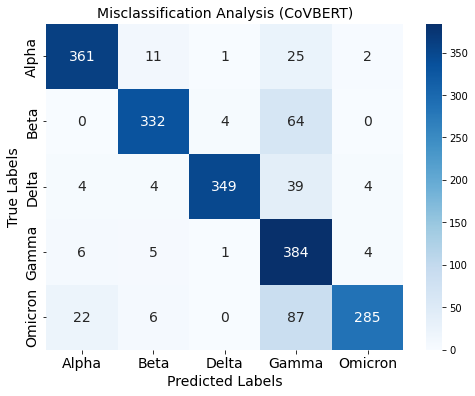

In [20]:
# Create a normalized confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the heatmap
plt.figure(figsize=(8, 6))
heatmap=sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=VOC_NAMES,
            yticklabels=VOC_NAMES,
            annot_kws={"fontsize": 14})

# Customize the x-axis and y-axis tick label font size
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=14)  # Increase the x-axis tick label font size here
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=14)  # Increase the y-axis tick label font size here

# Customize the plot
plt.title(f'Misclassification Analysis ({MODEL_PRINT_NAME}-{EMBED_SIZE})', fontsize=14)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels' , fontsize=14)
plt.savefig(f'figures/missclassification_{MODEL_PRINT_NAME}_{EMBED_SIZE}.pdf', bbox_inches='tight')
plt.show()

# SAVE AND LOAD MODEL

In [20]:
ckpt_dir = f"./checkpoints/{MODEL_PRINT_NAME}_{EMBED_SIZE}"
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

# Save tokenizer
tok.save_pretrained(ckpt_dir)

# Save model
model.save_pretrained(ckpt_dir)

In [21]:
# Load tokenizer
tok = AutoTokenizer.from_pretrained(ckpt_dir)

# Load model
loaded_model = AutoModelForSequenceClassification.from_pretrained(ckpt_dir)

# REFERENCES:

https://grabngoinfo.com/transfer-learning-for-text-classification-using-pytorch/